# A webapp to make online predict using `streamlit`


Users can draw several digits in a separated way (as long as it fits the blackbox). The app will first split them into respective numbers. Each image then will be carefully resized and handled to fit in the model as well as keep it real size. 

In [1]:
%%writefile app.py

from tensorflow.keras.models import load_model
import pandas as pd
from PIL import Image, ImageOps
import streamlit as st
from streamlit_drawable_canvas import st_canvas
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import torchvision
from datetime import datetime
import time

@st.cache(allow_output_mutation=True)
def get_model(model_path='/content/drive/MyDrive/Colab Notebooks/VEF - Machine Learning/vef final project/model_trained.model', compile=False):
    model = load_model(model_path)
    return model


def define_row_to_select_img(img_array):
  data = []
  for row_ in img_array:
    if (row_ == 0).all():
      data.append(0)
    else:
      data.append(1)
  return data

def get_index(array):
  result_array = []
  tmp = {}
  status = False
  for i in range(len(array)):
    row = array[i]

    if 'start' in tmp and 'end' in tmp:
      result_array.append(tmp)
      tmp = {}

    if status == False and row == 1:
      tmp['start'] = i
    elif status == True and row == 0:
      tmp['end'] = i + 1
    
    if row == 1:# row is not null
      status = True
    else: 
      status = False
    
  return result_array

def split_img(img_modified):
  array = define_row_to_select_img(img_modified)
  dict_ = get_index(array)
  for d in dict_:
    yield img_modified[d['start']:d['end']]

def resize_img(img_array):
  for i in img_array:
    i = np.rot90(i,1)
    x, y = i.shape
    print(x, y)
    if (x - y)%2 == 0:
      shape_1 = 200, int(((x-y)/2))
      shape_2 = shape_1
    else:
      shape_1 = 200, int(((x-y)+1)/2)
      shape_2 = 200, int(((x-y)-1)/2)
    i = np.c_[np.zeros((shape_1)), i, np.zeros((shape_2))]
    yield i

def main():
  Network = get_model()
  # Specify canvas parameters in application
  drawing_mode = 'freedraw'
  stroke_width = st.sidebar.slider("Stroke width: ", 1, 25, 13)
  stroke_color = '#ffffff'
  bg_color = '#000000'

  realtime_update = st.sidebar.checkbox("Update in realtime", True)
  
  st.write('# VEF FINAL PROJECT')
  st.write('## Digit Regconization with a `CNN` model')
  st.write('###  Draw a digit in 0-9')
  st.write('')
  # Create a canvas component
  canvas_result = st_canvas(
      fill_color="rgba(255, 165, 0, 0.3)",  # Fixed fill color with some opacity
      stroke_width=stroke_width,
      stroke_color=stroke_color,
      background_color=bg_color,
      # background_image=Image.open(bg_image) if bg_image else None,
      update_streamlit=realtime_update,
      height=200,
      width=700,
      drawing_mode=drawing_mode,
  )

  
  button_hit = st.button('Predict!')

  if button_hit:
    # Do something interesting with the image data and paths
    if canvas_result.image_data is not None:
        print(type(canvas_result.image_data))
        
        # Get the numpy array (4-channel RGBA 100,100,4)
        input_numpy_array = np.array(canvas_result.image_data)

        # Get the RGBA PIL image
        input_image = Image.fromarray(input_numpy_array.astype('uint8'), 'RGBA')
        input_image.save('user_input.png')
        
        # Convert it to grayscale
        input_image_gs = input_image.convert('L') # type PIL
        
        input_image_gs_np = np.asarray(input_image_gs.getdata()).reshape(200,700) # type NP Array

        img1 = Image.open('user_input.png')
        img1 = ImageOps.grayscale(img1) # PIL
        # Convert image to array
        input_numpy_array = np.array(img1)
        # Rotate image
        img_modified = np.rot90(input_numpy_array, 3)

        img_array = split_img(img_modified)
        img_array = resize_img(img_array)

        predict_numbers = ''
        for input_image_gs in img_array:
          

          print(type(input_image_gs))
          image = Image.fromarray(np.uint8(input_image_gs)) #convert('RGB')
          # Start creating a bounding box
          image = np.array(image)
          height, width = image.shape
          x,y,w,h = cv2.boundingRect(image)


          # Create new blank image and shift ROI to new coordinates
          ROI = image[y:y+h, x:x+w]
          mask = np.zeros([ROI.shape[0]+10,ROI.shape[1]+10])
          width, height = mask.shape
          x = width//2 - ROI.shape[0]//2 
          y = height//2 - ROI.shape[1]//2 
          mask[y:y+h, x:x+w] = ROI

          # Check if centering/masking was successful
          output_image = Image.fromarray(mask) # mask has values in [0-255] as expected
          # Now we need to resize, but it causes problems with default arguments as it changes the range of pixel values to be negative or positive
          # compressed_output_image = output_image.resize((22,22))
          # Therefore, we use the following:
          compressed_output_image = output_image.resize((22,22), Image.BILINEAR) # PIL.Image.NEAREST or PIL.Image.BILINEAR also performs good

          convert_tensor = torchvision.transforms.ToTensor()
          tensor_image = convert_tensor(compressed_output_image)
          # Another problem we face is that in the above ToTensor() command, we should have gotten a normalized tensor with pixel values in [0,1]
          # But somehow it doesn't happen. Therefore, we need to normalize manually
          tensor_image = tensor_image/255.
          # Padding
          tensor_image = torch.nn.functional.pad(tensor_image, (3,3,3,3), "constant", 0)
          # Normalization shoudl be done after padding
          convert_tensor = torchvision.transforms.Normalize((0.1307), (0.3081)) # Mean and std of MNIST
          tensor_image = convert_tensor(tensor_image)
          
          im = Image.fromarray(tensor_image.detach().cpu().numpy().reshape(28,28), mode='L')

          # export_time = datetime.now()
          im.save("processed_tensor.png", "PNG")
          # So we use matplotlib to save it instead
          plt.imsave("processed_tensor.png",tensor_image.detach().cpu().numpy().reshape(28,28), cmap='gray')

          st.write('### Processed image')
          st.image('processed_tensor.png')
          im = cv2.imread('processed_tensor.png', 0)
          im = np.array(im).reshape(28,28,1)
          
          predict = Network(im.reshape(1,28,28,1))
          predict_number = np.argmax(predict)
          predict_numbers += f' {predict_number} ' 

        st.write('### Prediction') 
        st.write('### '+ str(predict_numbers))
     
main()

Writing app.py


# Run streamlit by local tunnel

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

/bin/bash: streamlit: command not found
npx: installed 22 in 3.962s
your url is: https://legal-hairs-behave-34-90-246-12.loca.lt


And here the result of our webapp!

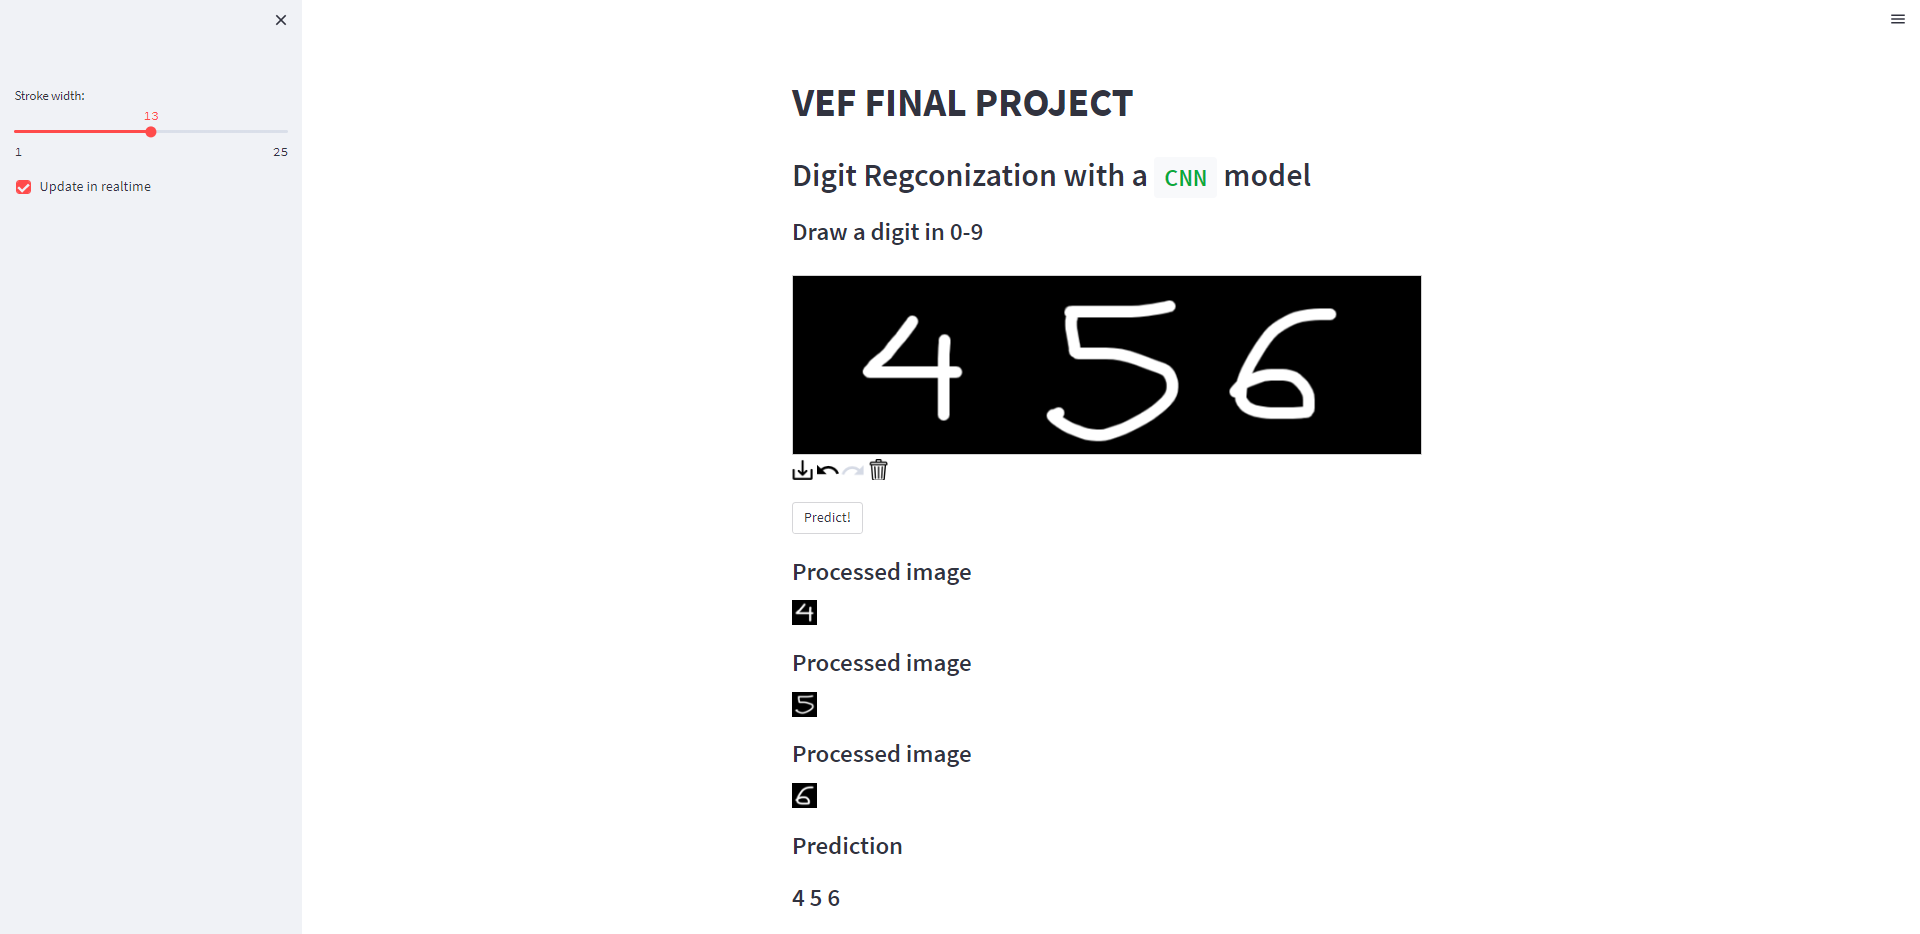